In [1]:
import os
import yaml
import tqdm
import time
import glob
import scipy
import random
import joblib
import logging
import subprocess
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import properscoring as ps
import multiprocessing as mp

from functools import partial

In [2]:
config = "config/SL.yml"

In [3]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [4]:
input_cols = conf["input_cols"]
output_cols = conf["output_cols"]

### Load data sets

In [5]:
ev_models = {}
ev_models["data"] = {}
ev_models["model"] = {}

In [6]:
ev_models["data"]["train"] = glob.glob("SL/lipschitz/data/*_2243/train.csv")
ev_models["data"]["valid"] = glob.glob("SL/lipschitz/data/*_2243/valid.csv")
ev_models["data"]["test"] = glob.glob("SL/lipschitz/data/*_2243/test.csv")
ev_models["model"]["train"] = glob.glob("SL/lipschitz/model/0_*/train.csv")
ev_models["model"]["valid"] = glob.glob("SL/lipschitz/model/0_*/valid.csv")
ev_models["model"]["test"] = glob.glob("SL/lipschitz/model/0_*/test.csv")

In [7]:
mlp_models = {}
mlp_models["data"] = {}
mlp_models["model"] = {}

In [8]:
mlp_models["data"]["train"] = glob.glob("SL/mlp/data/*_2243/train.csv")
mlp_models["data"]["valid"] = glob.glob("SL/mlp/data/*_2243/valid.csv")
mlp_models["data"]["test"] = glob.glob("SL/mlp/data/*_2243/test.csv")
mlp_models["model"]["train"] = glob.glob("SL/mlp/model/0_*/train.csv")
mlp_models["model"]["valid"] = glob.glob("SL/mlp/model/0_*/valid.csv")
mlp_models["model"]["test"] = glob.glob("SL/mlp/model/0_*/test.csv")

In [9]:
def load_and_concat(model_dict):
    for seed_type in ["data", "model"]:
        for split in ["valid", "test"]: # "train"
            print(f"Working on seed type: {seed_type} split: {split}")
            files = []
            for fn in model_dict[seed_type][split]:
                data, model = list(map(int, fn.split("/")[-2].split("_")))
                f = pd.read_csv(fn)
                f["data_seed"] = data
                f["model_seed"] = model
                files.append(f)
            model_dict[seed_type][split] = pd.concat(files)
    return model_dict

In [10]:
mlp_models = load_and_concat(mlp_models)

Working on seed type: data split: valid
Working on seed type: data split: test
Working on seed type: model split: valid
Working on seed type: model split: test


In [11]:
ev_models = load_and_concat(ev_models)

Working on seed type: data split: valid
Working on seed type: data split: test
Working on seed type: model split: valid
Working on seed type: model split: test


### Load the data from the ensembles

In [14]:
mlp_models["data"]["test"]["mlp_pred_error"] = abs(mlp_models["data"]["test"][output_cols[0]] - mlp_models["data"]["test"]["y_pred"])
mlp_models["model"]["test"]["mlp_pred_error"] = abs(mlp_models["model"]["test"][output_cols[0]] - mlp_models["model"]["test"]["y_pred"])

In [15]:
mlp_data = mlp_models["data"]["test"].groupby("Time").mean()
mlp_data["mlp_pred_std"] = mlp_models["data"]["test"].groupby("Time").std()["mlp_pred_error"]

In [16]:
mlp_model = mlp_models["model"]["test"].groupby("Time").mean()
mlp_model["mlp_pred_std"] = mlp_models["model"]["test"].groupby("Time").std()["mlp_pred_error"]

In [17]:
ev_models["data"]["test"]["y_pred_error"] = abs(ev_models["data"]["test"][output_cols[0]] - ev_models["data"]["test"]["mu"])
ev_models["model"]["test"]["y_pred_error"] = abs(ev_models["model"]["test"][output_cols[0]] - ev_models["model"]["test"]["mu"])

In [18]:
ev_data = ev_models["data"]["test"].groupby("Time").mean()
ev_data["y_pred_std"] = ev_models["data"]["test"].groupby("Time").std()["mu"]

In [19]:
ev_model = ev_models["model"]["test"].groupby("Time").mean()
ev_model["y_pred_std"] = ev_models["model"]["test"].groupby("Time").std()["mu"]

### Load the best performing evidential model from the data ensemble

In [20]:
performance_ev = ev_models["data"]["test"].groupby("data_seed").mean()["y_pred_error"]
best_model = performance_ev.index[np.where(performance_ev == performance_ev.max())][0]
best_evidential = ev_models["data"]["test"][ev_models["data"]["test"]["data_seed"] == best_model].copy()

In [22]:
# inverse_evidence = 1. / ((best_evidential["alpha"].copy()-1) * best_evidential["v"])
# variance = best_evidential["beta"] * inverse_evidence
# sigma = best_evidential[output_cols[0]].std()

In [23]:
best_evidential["ev_error"] = abs(best_evidential["mu"] - best_evidential[output_cols[0]])
#best_evidential["variance"] = (variance * sigma**2)
#best_evidential["confidence"] = (inverse_evidence * sigma**2)

In [24]:
best_evidential = best_evidential.rename(columns = {
    "var": "variance", 
    "conf": "confidence"
})

In [25]:
keep_cols = ["Time"] + output_cols + ['mu', "ev_error", 'v', 'alpha', 'beta', "variance", "confidence"]
best_evidential = best_evidential[keep_cols].copy()

In [26]:
print(best_evidential["ev_error"].mean(), np.sqrt(best_evidential["variance"].mean()))

0.03711709721240187 0.05984096608361657


In [27]:
print(mlp_data["mlp_pred_error"].mean(), np.sqrt(mlp_data["mlp_pred_std"].mean()))

0.03423463942941637 0.06562328721715015


In [28]:
print(mlp_model["mlp_pred_error"].mean(), np.sqrt(mlp_model["mlp_pred_std"].mean()))

0.03615842163446838 0.03985554370049185


In [29]:
def compute_cov(df, col = "var", quan = "error"):
    df = df.copy()
    df = df.sort_values(col, ascending = True)
    df["dummy"] = 1
    df[f"cu_{quan}"] = df[quan].cumsum() / df["dummy"].cumsum()
    df[f"cu_{col}"] = df[col].cumsum() / df["dummy"].cumsum()
    df[f"{col}_cov"] = 1 - df["dummy"].cumsum() / len(df)
    return df

In [30]:
ev_variance = compute_cov(best_evidential, col = "variance", quan = "ev_error")
ev_evidence = compute_cov(best_evidential, col = "confidence", quan = "ev_error")
mlp_data_std = compute_cov(mlp_data, col = "mlp_pred_std", quan = "mlp_pred_error")
mlp_model_std = compute_cov(mlp_model, col = "mlp_pred_std", quan = "mlp_pred_error")

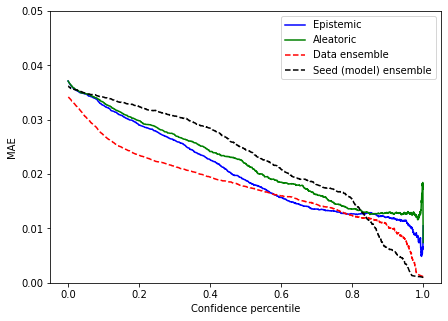

In [31]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(ev_variance["variance_cov"], ev_variance["cu_ev_error"], zorder = 2, color = 'b')
ax.plot(ev_evidence["confidence_cov"], ev_evidence["cu_ev_error"], zorder = 2, color = 'g')
ax.plot(mlp_data_std["mlp_pred_std_cov"], mlp_data_std["cu_mlp_pred_error"], zorder = 2, color = 'r', ls = "--")
ax.plot(mlp_model_std["mlp_pred_std_cov"], mlp_model_std["cu_mlp_pred_error"], zorder = 2, color = 'k', ls = "--")
ax.set_xlabel("Confidence percentile")
ax.set_ylabel("MAE")

#ax.set_xlim([0.0, 0.4])
ax.set_ylim([0.0, 0.05])

ax.legend(["Epistemic", "Aleatoric", "Data ensemble", "Seed (model) ensemble"])

In [32]:
def calibration_curve(df, col = "var", quan = "error", bins = 20):
    obs = df.sort_values(quan, ascending = True).copy()
    obs[f"{quan}_cov"] = 1 - obs["dummy"].cumsum() / len(obs)
    h, b1, b2, _ = ax.hist2d(obs[f"{col}_cov"], obs[f"{quan}_cov"], bins = bins)
    cov_var = np.arange(0.025, 1.025, 0.05)
    cov_mae = [np.average(cov_var, weights = hi) for hi in h]
    cov_mae_std = [np.average((cov_mae-cov_var)**2, weights=hi) for hi in h]
    cov_var_std = [np.average((cov_mae-cov_var)**2, weights=hi) for hi in h.T]
    return cov_var, cov_mae, cov_mae_std, cov_var_std

In [33]:
#h, b1, b2, _ = ax.hist2d(obs["variance_cov"], obs["ev_error_cov"], bins = 20)

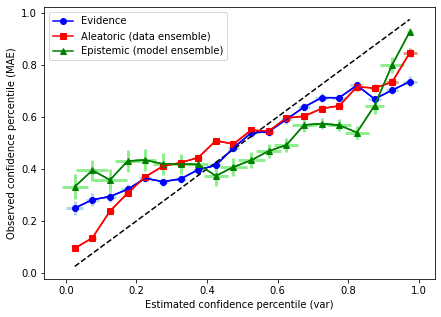

In [34]:
# cov_var = np.arange(0.025, 1.025, 0.05)
# cov_mae = [np.average(cov_var, weights = hi) for hi in h]
# cov_mae_std = [np.average((cov_mae-cov_var)**2, weights=hi) for hi in h]
# cov_var_std = [np.average((cov_mae-cov_var)**2, weights=hi) for hi in h.T]

results = {"ev": {}, "data": {}, "model": {}}

cov_var, cov_mae, cov_mae_std, cov_var_std = calibration_curve(
    ev_variance, col = "variance", quan = "ev_error", bins = 20)

results["ev"]["mae"] = cov_mae
results["ev"]["variance"] = cov_var
results["ev"]["mae_std"] = cov_mae_std
results["ev"]["var_std"] = cov_var_std

cov_var, cov_mae, cov_mae_std, cov_var_std = calibration_curve(
    mlp_data_std, col = "mlp_pred_std", quan = "mlp_pred_error", bins = 20)

results["data"]["mae"] = cov_mae
results["data"]["variance"] = cov_var
results["data"]["mae_std"] = cov_mae_std
results["data"]["var_std"] = cov_var_std

cov_var, cov_mae, cov_mae_std, cov_var_std = calibration_curve(
    mlp_model_std, col = "mlp_pred_std", quan = "mlp_pred_error", bins = 20)

results["model"]["mae"] = cov_mae
results["model"]["variance"] = cov_var
results["model"]["mae_std"] = cov_mae_std
results["model"]["var_std"] = cov_var_std

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(results["ev"]["variance"], results["ev"]["mae"],  "b-o")
ax.errorbar(results["ev"]["variance"], results["ev"]["mae"], 
            xerr = results["ev"]["var_std"], 
            yerr = results["ev"]["mae_std"], capsize=0, c = "b", elinewidth=3, ecolor='lightblue')

ax.plot(results["data"]["variance"], results["data"]["mae"], "r-s")
ax.errorbar(results["data"]["variance"], results["data"]["mae"], 
            xerr = results["data"]["var_std"], 
            yerr = results["data"]["mae_std"], capsize=0, c = "r", elinewidth=3, ecolor='darksalmon')

ax.plot(results["model"]["variance"], results["model"]["mae"], "g-^")
ax.errorbar(results["model"]["variance"], results["model"]["mae"], 
            xerr = results["model"]["var_std"], 
            yerr = results["model"]["mae_std"], capsize=0, c = "g", elinewidth=3, ecolor='lightgreen')

# fmt='o', color='black',
#              ecolor='lightgray', elinewidth=3, capsize=0

ax.plot(results["ev"]["variance"], results["ev"]["variance"], 'k--')

ax.set_xlabel("Estimated confidence percentile (var)")
ax.set_ylabel("Observed confidence percentile (MAE)")


ax.legend(["Evidence", "Aleatoric (data ensemble)", "Epistemic (model ensemble)"])

#ax.set_xlim([0,1])
#ax.set_ylim([0,1])

In [114]:
mlp_model

,Unnamed: 0,wind_speed:2_m:m_s-1,wind_gust:2_m:m_s-1,wind_direction:2_m:degrees,sigma_theta:2_m:degrees,wind_speed:10_m:m_s-1,wind_gust:10_m:m_s-1,wind_direction:10_m:degrees,sigma_theta:10_m:degrees,wind_speed:15_m:m_s-1,...,virtual_potential_temperature_skin_change:2_m:K_m-1,mixing_ratio_skin_change:2_m:g_kg-1_m-1,moisture_availability:soil:None,kinematic_sensible_heat_flux:surface:K_m_s-1,kinematic_latent_heat_flux:surface:g_kg-1_m_s-1,y_pred,data_seed,model_seed,mlp_pred_error,mlp_pred_std
Time,,,,,,,,,,,,,,,,,,,,,
2015-03-31 00:00:00,998.0,1.4,1.6,240.3,6.9,3.5,3.8,229.8,3.1,3.6,...,1.538057,-0.129512,0.069967,-0.013416,-0.000245,-0.021628,0.0,2296.55,0.008211,0.001297
2015-03-31 00:30:00,999.0,1.2,1.3,196.0,7.0,3.3,3.9,218.0,3.7,4.3,...,1.435482,-0.106464,0.064738,-0.000898,-0.000117,-0.017739,0.0,2296.55,0.016841,0.001179
2015-03-31 01:00:00,1000.0,1.6,1.8,197.9,6.1,3.1,3.4,214.5,4.0,3.5,...,1.687295,-0.103463,0.066451,0.003230,0.000021,-0.011195,0.0,2296.55,0.014425,0.001226
2015-03-31 01:30:00,1001.0,1.3,1.9,163.8,10.9,2.6,3.2,182.8,7.8,3.0,...,1.574729,-0.105800,0.068194,-0.003686,-0.000151,-0.008132,0.0,2296.55,0.004446,0.001261
2015-03-31 02:00:00,1002.0,1.5,2.1,352.5,16.5,1.4,2.0,312.5,26.8,1.4,...,1.377281,-0.083308,0.066451,-0.004816,-0.000060,-0.005089,0.0,2296.55,0.001047,0.000728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-28 18:30:00,37045.0,1.0,1.3,337.2,10.0,2.4,2.6,7.1,2.6,2.8,...,2.190103,0.003364,0.020280,-0.000888,0.000098,-0.017896,0.0,2296.55,0.017009,0.001411
2017-12-28 19:00:00,37046.0,0.7,1.0,196.5,25.3,0.6,0.9,41.1,33.7,1.1,...,1.941022,0.002105,0.019527,-0.000054,0.000115,-0.001957,0.0,2296.55,0.002066,0.001468
2017-12-28 19:30:00,37047.0,0.8,1.0,340.4,11.8,1.9,2.1,29.3,5.5,2.6,...,2.442648,0.003559,0.017388,-0.006277,-0.000104,-0.014626,0.0,2296.55,0.008349,0.001425


In [115]:
mlp_model.index

Index(['2015-03-31 00:00:00', '2015-03-31 00:30:00', '2015-03-31 01:00:00',
       '2015-03-31 01:30:00', '2015-03-31 02:00:00', '2015-03-31 02:30:00',
       '2015-03-31 03:00:00', '2015-03-31 03:30:00', '2015-03-31 04:00:00',
       '2015-03-31 04:30:00',
       ...
       '2017-12-28 16:00:00', '2017-12-28 16:30:00', '2017-12-28 17:00:00',
       '2017-12-28 17:30:00', '2017-12-28 18:00:00', '2017-12-28 18:30:00',
       '2017-12-28 19:00:00', '2017-12-28 19:30:00', '2017-12-28 20:00:00',
       '2017-12-28 20:30:00'],
      dtype='object', name='Time', length=3834)

In [118]:
best_evidential["day"] = best_evidential["Time"].apply(lambda x: str(x).split(" ")[0])
mlp_model["day"] = mlp_model.index.map(lambda x: str(x).split(" ")[0])
mlp_data["day"] = mlp_data.index.map(lambda x: str(x).split(" ")[0])

In [109]:
days = ['2016-02-17', '2017-04-22', '2017-08-04'] #random.choices(best_evidential["day"].unique(), k = 3)

In [106]:
random.choices(best_evidential["day"].unique(), k = 3)

['2015-06-13', '2017-11-21', '2017-08-04']

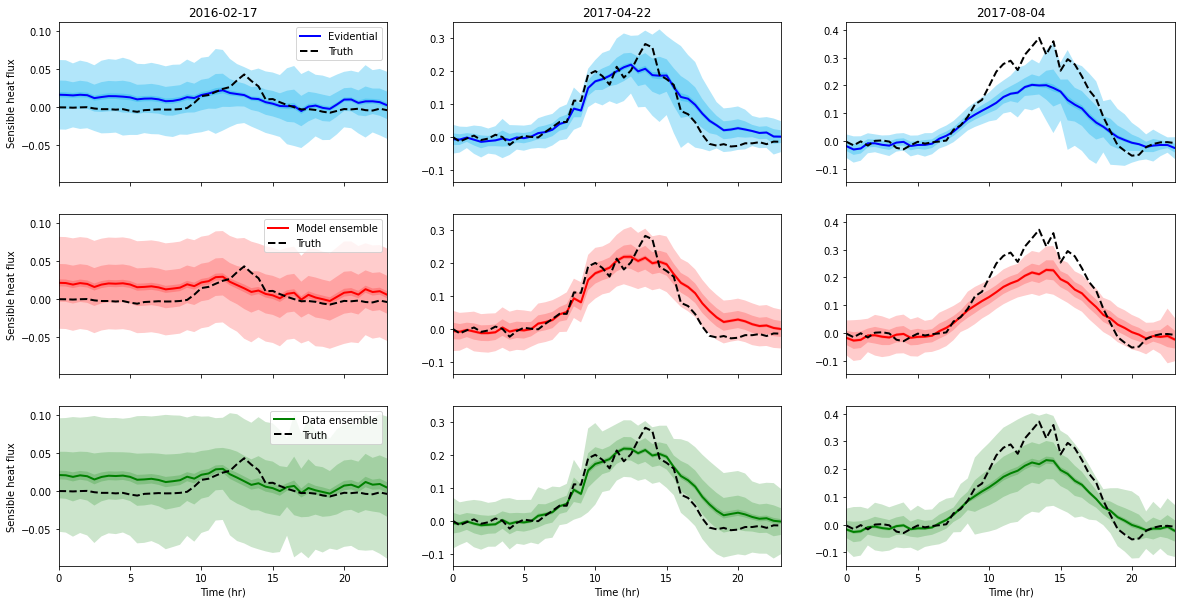

In [120]:
fig, ax = plt.subplots(3, 3, figsize=(20, 10), sharex=True, sharey='col')

times = range(len(mlp_models["data"]["test"]['Time'].unique()))
time_steps = sorted(mlp_models["data"]["test"]['Time'].unique())
sorted_best_evidential = best_evidential.merge(pd.DataFrame.from_dict({"Time": time_steps}), on = ["Time"], how = "right")
sorted_mlp_model = mlp_model.merge(pd.DataFrame.from_dict({"Time": time_steps}), on = ["Time"], how = "right")
sorted_mlp_data = mlp_data.merge(pd.DataFrame.from_dict({"Time": time_steps}), on = ["Time"], how = "right")

for d, day in enumerate(days):
    c = best_evidential["day"] == day
    t_range = range(c.sum())
    t_range = [0.5 * x for x in t_range]
    
    ax[0][d].plot(t_range, sorted_best_evidential["mu"][c], color='b', lw=2)

    n_stds = 4
    mu = sorted_best_evidential["mu"][c]
    var = sorted_best_evidential["variance"][c] ** (1/2)

    #for k in np.linspace(0, n_stds, 4):
    conf_percentiles = [0.1, 0.5, 0.9]

    for k in conf_percentiles:
        ub, lb = scipy.stats.norm.interval(k, loc=mu, scale=var)
        ax[0][d].fill_between(
            t_range, lb, ub,
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1)


    ### Model
    c = sorted_mlp_model["day"] == day
    ax[1][d].plot(t_range, sorted_mlp_model["y_pred"][c] , color='r', lw=2)

    mu = sorted_mlp_model["y_pred"][c]
    var = sorted_mlp_model["mlp_pred_std"][c] ** (1/2)
    #for k in np.linspace(0, n_stds, 4):
    for k in conf_percentiles:
        ub, lb = scipy.stats.norm.interval(k, loc=mu, scale=var)
        ax[1][d].fill_between(
            t_range, lb, ub,
            alpha=0.2,
            edgecolor=None,
            facecolor='red',
            linewidth=0,
            zorder=1)
    
    ### Data   
    c = sorted_mlp_data["day"] == day
    ax[2][d].plot(t_range, sorted_mlp_data["y_pred"][c] , color='g', lw=2, zorder=2)

    mu = sorted_mlp_data["y_pred"][c]
    var = sorted_mlp_data["mlp_pred_std"][c] ** (1/2)
    #for k in np.linspace(0, n_stds, 4):
    for k in conf_percentiles:
        ub, lb = scipy.stats.norm.interval(k, loc=mu, scale=var)
        ax[2][d].fill_between(
            t_range, lb, ub,
            alpha=0.2,
            edgecolor=None,
            facecolor='green',
            linewidth=0,
            zorder=1)
    
    for i in [0,1,2]:
        ax[i][d].plot(t_range, sorted_mlp_data[output_cols[0]][c], 'k--', lw=2, zorder=2)
        ax[i][d].set_xlim([0, 23])
        if d == 0:
            ax[i][d].set_ylabel("Sensible heat flux")
            
        if i == 0:
            ax[i][d].set_title(day)
            
        if i == 2:
            ax[i][d].set_xlabel("Time (hr)")

#ax[0][d].set_ylim([-0.3, 0.6])
#ax[1][d].set_ylim([-0.3, 0.6])
#ax[2][d].set_ylim([-0.3, 0.6])

ax[0][0].legend(["Evidential", "Truth"])
ax[1][0].legend(["Model ensemble", "Truth"])
ax[2][0].legend(["Data ensemble", "Truth"])
#plt.tight_layout()

### CRPS computation

In [101]:
def helper(stuff, df=None, t_phase=None, p_phase=None, n_bs_samples=1000, ci_level=0.95):
    
    num_exps = df["data_seed"].nunique()
    min_quant = (1 - ci_level) / 2
    max_quant = 1 - min_quant
    
    k, time_steps = stuff
    crps, upper_ci, lower_ci = [], [], []
    for time_step in time_steps:
        bs_crps = []
        t_sub = df[df['Time'] == time_step][t_phase]
        p_sub = df[df['Time'] == time_step][p_phase]#.unstack('data_seed')
        crps_sub = ps.crps_ensemble(t_sub, p_sub)
        crps.append(crps_sub.mean())
        for _ in range(n_bs_samples):
            sample_crps = np.random.choice(crps_sub, num_exps, replace=True)
            bs_crps.append(sample_crps.mean())
        upper_ci.append(np.quantile(bs_crps, max_quant))
        lower_ci.append(np.quantile(bs_crps, min_quant))
    return [x for x in time_steps], crps, upper_ci, lower_ci
    
def crps_ens_bootstrap(df, t_cols, p_cols, n_bs_samples=1000, ci_level=0.95, pool = None):
    """
    Calculate Continuous Ranked Probability Score across validation experiments for ensemble
    Args:
        truth (pd.DataFrame): Modeled observations
        preds (pd.DataFrame): Predictions
        columns: Columns to calculate CRPS on
        n_bs_samples (int): Number of bootstrap resamples (defaults to 1000)
        ci_level (float): Confidence level in decimal form (defaults to 0.95)
    Returns:
        (Dicts): Mean CRPS, Lower CRPS CI, Upper CRPS CI
    """

    num_exps = df["data_seed"].nunique()
    time_steps = sorted(df['Time'].unique())
    min_quant = (1 - ci_level) / 2
    max_quant = 1 - min_quant
    all_crps, all_upper_ci, all_lower_ci = {}, {}, {}

    for t_phase, p_phase in zip(t_cols, p_cols):

        all_times = []
        crps, upper_ci, lower_ci = [], [], []
        
        worker = partial(helper, df=df, 
                         t_phase=t_phase, p_phase=p_phase, 
                         n_bs_samples=n_bs_samples, ci_level=ci_level)
        
        n_splits = 100
        splits = np.array_split(time_steps, n_splits)
        for result in tqdm.tqdm(p.imap(worker, enumerate(splits)), total = n_splits):
            all_times += result[0]
            crps += result[1]
            upper_ci += result[2]
            lower_ci += result[3]
        all_crps[t_phase] = crps
        all_upper_ci[t_phase] = upper_ci
        all_lower_ci[t_phase] = lower_ci

    return all_times, all_crps, all_lower_ci, all_upper_ci

In [103]:
with mp.Pool(8) as p:
    time_steps, mlp_crps, mlp_lower_ci, mlp_upper_ci = crps_ens_bootstrap(
        mlp_models["data"]["test"], 
        output_cols,
        ["y_pred"],
        n_bs_samples=10, 
        ci_level=0.95,
        pool = p
    )

100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


In [104]:
times = range(len(mlp_models["data"]["test"]['Time'].unique()))

(100.0, 200.0)

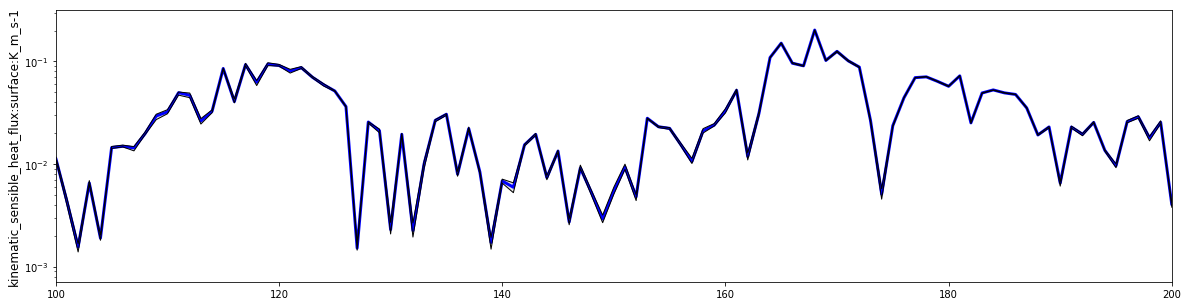

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5), sharex=True)

ax.plot(times, mlp_crps[output_cols[0]], color="b", lw=3, label=f'Mean CRPS')
ax.plot(times, mlp_lower_ci[output_cols[0]], color='k', lw=1)
ax.plot(times, mlp_upper_ci[output_cols[0]], color='k', lw=1)
ax.fill_between(times, mlp_lower_ci[output_cols[0]], mlp_upper_ci[output_cols[0]], alpha=0.2, color='grey')
ax.set_ylabel(output_cols[0], fontsize=12)
ax.set_yscale("log")

ax.set_xlim([100, 200])